<a href="https://colab.research.google.com/github/Manu-Sanchez/Learning/blob/ai%2Fbasic-gan/TabularModel%26FeatureEngineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import math

%matplotlib inline

In [3]:
df = pd.read_csv("NYCTaxiFares.csv")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1.0
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1.0
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2.0
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1.0
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1.0


## Data Treatment

In [13]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers

    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])

    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])

    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [9]:
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1.0
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1.0
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2.0
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1.0
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1.0


In [12]:
df["local_datetime"] = df["pickup_datetime"] - pd.Timedelta(hours=4)
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,local_datetime
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1.0,2010-04-19 04:17:56+00:00
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1.0,2010-04-17 11:43:53+00:00
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2.0,2010-04-17 07:23:26+00:00
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1.0,2010-04-11 17:25:03+00:00
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1.0,2010-04-16 22:19:01+00:00


In [14]:
df["dist_km"] = haversine_distance(df, "pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,local_datetime,dist_km
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1.0,2010-04-19 04:17:56+00:00,2.126312
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1.0,2010-04-17 11:43:53+00:00,1.392307
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2.0,2010-04-17 07:23:26+00:00,3.326763
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1.0,2010-04-11 17:25:03+00:00,1.864129
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1.0,2010-04-16 22:19:01+00:00,7.231321


In [18]:
df["hour"] = df["local_datetime"].dt.hour
df["am_or_pm"] = np.where(df['hour']<12, "am", "pm")
df["weekday"] = df["local_datetime"].dt.strftime("%a")

df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,local_datetime,dist_km,hour,am_or_pm,weekday
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1.0,2010-04-19 04:17:56+00:00,2.126312,4,am,Mon
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1.0,2010-04-17 11:43:53+00:00,1.392307,11,am,Sat
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2.0,2010-04-17 07:23:26+00:00,3.326763,7,am,Sat
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1.0,2010-04-11 17:25:03+00:00,1.864129,17,pm,Sun
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1.0,2010-04-16 22:19:01+00:00,7.231321,22,pm,Fri


## Column classification and categorization

In [28]:
categorical_columns = [
    "hour",
    "weekday",
    "am_or_pm"
]

continuous_columns = [
    "dist_km",
    "passenger_count"
]

y_column = "fare_amount"


categorical_data = []
for cat_col in categorical_columns:
  df[cat_col] = df[cat_col].astype('category')
  categorical_data.append(df[cat_col].cat.codes.values)


categorical_data = np.stack(categorical_data, axis=1)
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)

print(f"Categorical Data Shape: {categorical_data.shape}")

continuous_data = []
for cont_col in continuous_columns:
  continuous_data.append(df[cont_col].values)

continuous_data = np.stack(continuous_data, axis=1)
continuous_data = torch.tensor(continuous_data, dtype=torch.float)

print(f"Continuous Data Shape: {continuous_data.shape}")

y_data = torch.tensor(df[y_column], dtype=torch.float).reshape(-1, 1)
print(f"Y Data Shape: {y_data.shape}")

Categorical Data Shape: torch.Size([69996, 3])
Continuous Data Shape: torch.Size([69996, 2])
Y Data Shape: torch.Size([69996, 1])


## Embedding Size Definition

In [29]:
category_number = []
category_embedding_size = []

for cat_col in categorical_columns:
  category_number.append(len(df[cat_col].cat.categories.values))
  category_embedding_size.append((category_number[-1], (category_number[-1] + 1)// 2))

print(category_number)
print(category_embedding_size)

[24, 7, 2]
[(24, 12), (7, 4), (2, 1)]


## Model Definition

In [58]:
class TabularModel(nn.Module):

  def __init__(self, category_embedding_size, continuous_column_number, output_size, layers, dropout=0.5):
    super().__init__()

    self.embedding_model = nn.ModuleList([nn.Embedding(cat_size, cat_emb_size) for cat_size, cat_emb_size in category_embedding_size])
    self.embedding_dropout = nn.Dropout(dropout)
    self.continuous_data_norm = nn.BatchNorm1d(continuous_column_number)

    layer_list = []
    category_column_number = sum([cat_emb_size for cat_size, cat_emb_size in category_embedding_size])
    in_features = category_column_number + continuous_column_number

    for i in layers:
      layer_list.append(nn.Linear(in_features, i))
      layer_list.append(nn.ReLU(inplace=True))
      layer_list.append(nn.BatchNorm1d(i))
      layer_list.append(nn.Dropout(dropout))
      in_features = i

    layer_list.append(nn.Linear(layers[-1], output_size))

    self.layers = nn.Sequential(*layer_list)


  def forward(self, x_cat, x_cont):

    embedding_results = []

    for idx, embedding_layer in enumerate(self.embedding_model):
      embedding_results.append(embedding_layer(x_cat[:, idx]))

    x = torch.cat(embedding_results, 1)
    x = self.embedding_dropout(x)

    x_cont = self.continuous_data_norm(x_cont)

    x = torch.cat([x, x_cont], 1)
    x = self.layers(x)

    return x

model = TabularModel(category_embedding_size, len(continuous_columns), 1, [200, 100], 0.4)
model

TabularModel(
  (embedding_model): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(7, 4)
    (2): Embedding(2, 1)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (continuous_data_norm): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=19, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [59]:
criterion = nn.MSELoss() #np.sqrt(MSE) --> RMSE
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [60]:
nRows, nCols = df.shape

maxSize = min(60000, nRows)
trainSize = int(maxSize*0.9)
testSize = maxSize - trainSize

print(f"Expected Shape: {(trainSize, testSize)}")

categorical_train_data = categorical_data[:trainSize]
categorical_test_data = categorical_data[trainSize:maxSize]

print(categorical_train_data.shape)
print(categorical_test_data.shape)

continuous_train_data = continuous_data[:trainSize]
continuous_test_data = continuous_data[trainSize:maxSize]

print(continuous_train_data.shape)
print(continuous_test_data.shape)

y_train_data = y_data[:trainSize]
y_test_data = y_data[trainSize:maxSize]

print(y_train_data.shape)
print(y_test_data.shape)


Expected Shape: (54000, 6000)
torch.Size([54000, 3])
torch.Size([6000, 3])
torch.Size([54000, 2])
torch.Size([6000, 2])
torch.Size([54000, 1])
torch.Size([6000, 1])


In [61]:
epochs = 300
losses = []

for i in range(epochs):
  i+=1

  y_pred = model(categorical_train_data, continuous_train_data)
  loss = torch.sqrt(criterion(y_pred, y_train_data))
  losses.append(loss.detach().numpy())

  print(f"Epoch {i} loss {loss}")

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch 1 loss 12.486553192138672
Epoch 2 loss 12.392472267150879
Epoch 3 loss 12.28147029876709
Epoch 4 loss 12.185678482055664
Epoch 5 loss 12.084967613220215
Epoch 6 loss 11.987916946411133
Epoch 7 loss 11.892752647399902
Epoch 8 loss 11.796056747436523
Epoch 9 loss 11.710149765014648
Epoch 10 loss 11.617659568786621
Epoch 11 loss 11.530957221984863
Epoch 12 loss 11.450430870056152
Epoch 13 loss 11.377318382263184
Epoch 14 loss 11.2960205078125
Epoch 15 loss 11.222726821899414
Epoch 16 loss 11.159125328063965
Epoch 17 loss 11.096423149108887
Epoch 18 loss 11.033870697021484
Epoch 19 loss 10.977075576782227
Epoch 20 loss 10.929180145263672
Epoch 21 loss 10.883265495300293
Epoch 22 loss 10.836684226989746
Epoch 23 loss 10.794017791748047
Epoch 24 loss 10.74896240234375
Epoch 25 loss 10.720797538757324
Epoch 26 loss 10.673880577087402
Epoch 27 loss 10.653888702392578
Epoch 28 loss 10.62590217590332
Epoch 29 loss 10.586553573608398
Epoch 30 loss 10.56191635131836
Epoch 31 loss 10.53895568

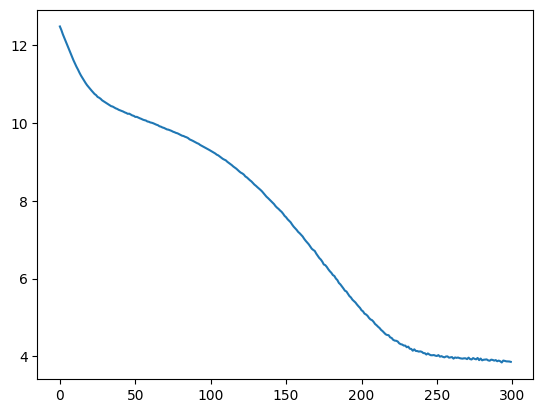

In [62]:
plt.plot(range(epochs), losses)

In [63]:
with torch.no_grad():

  y_val = model(categorical_test_data, continuous_test_data)

  loss = torch.sqrt(criterion(y_val, y_test_data))

print(loss)

tensor(3.9702)


In [73]:
for i in range(20):

  y_value = y_test_data[i].item()
  y_predicted_value = y_val[i].item()
  diff = np.abs(y_value - y_predicted_value)

  print(f"Original Value {y_value:8.2f} \t Predicted {y_predicted_value:8.2f} \t Diff {diff:8.2f}")

Original Value     8.50 	 Predicted     9.06 	 Diff     0.56
Original Value    11.30 	 Predicted     9.37 	 Diff     1.93
Original Value    24.90 	 Predicted    14.19 	 Diff    10.71
Original Value    16.10 	 Predicted    14.98 	 Diff     1.12
Original Value     9.70 	 Predicted     4.70 	 Diff     5.00
Original Value    30.27 	 Predicted    28.28 	 Diff     1.99
Original Value     9.30 	 Predicted     6.22 	 Diff     3.08
Original Value    15.30 	 Predicted    11.60 	 Diff     3.70
Original Value    26.67 	 Predicted    17.97 	 Diff     8.70
Original Value     9.30 	 Predicted    12.87 	 Diff     3.57
Original Value     9.70 	 Predicted     9.11 	 Diff     0.59
Original Value    17.30 	 Predicted    20.77 	 Diff     3.47
Original Value     7.70 	 Predicted    11.51 	 Diff     3.81
Original Value     5.70 	 Predicted     4.00 	 Diff     1.70
Original Value     4.50 	 Predicted     7.20 	 Diff     2.70
Original Value     5.70 	 Predicted     7.61 	 Diff     1.91
Original Value     6.90 

In [1]:
torch.save(model.state_dict(), "taxi.pt")

NameError: ignored